!pip install -r requirements_29.txt

# Intro
This sample notebook demonstrates the use of HANA Graph extensions of the "SAP HANA python client API for machine learning algorithms" (aka python client, HANA-ML).
In this notebook, we will download OpenStreetMap data from London, UK using osmnx. The road network consists of road segment and junctions. Two HANA dataframes will be created and a HANA Graph is defined on top of these two dataframes. A neighbors-induced sub-graph and a shortest path is calculated in the HANA database using its graph features. The resulting sub-graph and path is visualized using Kepler.gl.

You need to have you python environment set up properly (see..) and you need to have a SAP HANA Cloud database to connect to.

Download hana-ml python package:<br>
https://pypi.org/project/hana-ml/

Documentation:<br>
https://help.sap.com/doc/1d0ebfe5e8dd44d09606814d83308d4b/2.0.05/en-US/index.html#

SAP HANA Trial:<br>
https://www.sap.com/cmp/td/sap-hana-cloud-trial.html

SAP HANA Cloud Graph reference:<br>
https://help.sap.com/viewer/11afa2e60a5f4192a381df30f94863f9/latest/en-US




# Setting the environment

In [53]:
# Popular tools
import pandas as pd                                     # main table handling in the notebook with numpy columns
import geopandas as gpd                                 # main geo visualization with extension of shapely columns
import osmnx as ox                                      # open source spatial intelligence (OSpINT)
from keplergl import KeplerGl                           # advanced geo visualization
# HANA-ML
import hana_ml
import hana_ml.graph as hana_graph

# Connecting to a SAP HANA database
You can register for the 30-days free trial of SAP HANA Cloud which you can use.
SAP HANA Cloud is a service on the SAP Cloud Platform. 

https://www.sap.com/cmp/td/sap-hana-cloud-trial.html

### Set the parameters used to connect to HANA Cloud

In [2]:
url = 'somehost.hana.trial-eu10.hanacloud.ondemand.com'
port = 443
user = 'your_user'
pwd = 'your_password'

### Connect to HANA using the hana_ml.ConnectionContext

In [4]:
cc = hana_ml.ConnectionContext(url, port, user, pwd)
print('HANA version: ' + cc.hana_version())
print('Current schema: ' + cc.get_current_schema())
schema = cc.get_current_schema()

HANA version: 4.00.000.00.1624913057 (fa/CE2021.18)
Current schema: GRAPH_USER


# Using osmnx to get OpenStreetMap and POI data
see https://github.com/gboeing/osmnx

### Set the parameters used to get OSM data
There are different network types like ‘walk’, ‘bike’, ‘drive’, ‘drive_service’, ‘all’, or ‘all_private’.
osmnx can get the raod graph based on a place name, e.g. London, UK, or a gelocation. We use geolocation.

In [5]:
network_type='walk'
point = (51.507222, -0.1275)

### Get the OSM data via osmnx

In [6]:
G = ox.graph_from_point(point, dist=500, network_type=network_type, simplify=False)

### Extracting the edges(=street segments) and vertices(=junctions)

In [7]:
vertices_gdf, edges_gdf = ox.graph_to_gdfs(G)

### Plot the network

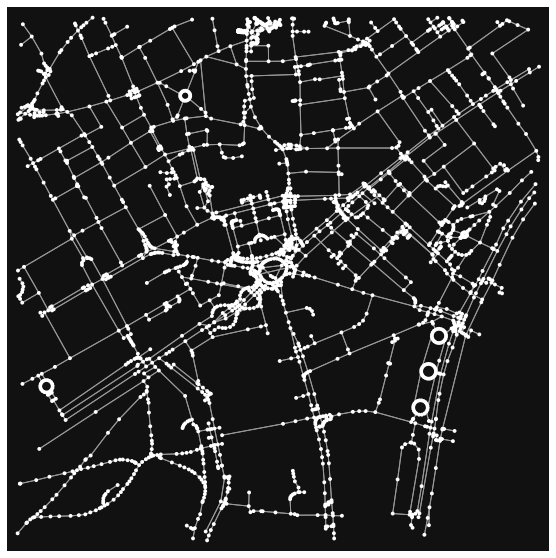

In [8]:
fig, ax = ox.plot_graph(G, figsize=(10, 10))

### Inspect the vertices and edges
The vertices contain a geometry, i.e. the geolocation of the junction

In [45]:
vertices_gdf = vertices_gdf.reset_index(level=['osmid'])
vertices_gdf.head(5)

,osmid,y,x,street_count,highway,ref,geometry
0,107715,51.510573,-0.121090,4,NaN,NaN,POINT (-0.12109 51.51057)
1,107763,51.505626,-0.126696,4,NaN,NaN,POINT (-0.12670 51.50563)
2,107768,51.506673,-0.123027,2,NaN,NaN,POINT (-0.12303 51.50667)
3,107769,51.506945,-0.124915,3,NaN,NaN,POINT (-0.12492 51.50694)
4,107770,51.507179,-0.127566,4,crossing,NaN,POINT (-0.12757 51.50718)


In [46]:
edges_gdf = edges_gdf.reset_index(level=['u', 'v', 'key'])
edges_gdf.head(5)

,u,v,key,osmid,name,highway,maxspeed,oneway,length,lanes,ref,access,junction,service,tunnel,bridge,width,geometry
0,107715,4350208168,0,4253954,Savoy Court,residential,5 mph,False,9.135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (-0.12109 51.51057, -0.12103 51.51050)"
1,107715,7283823188,0,200596105,Strand,primary,20 mph,False,23.561,2,A4,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (-0.12109 51.51057, -0.12138 51.51046)"
2,107715,7283808384,0,200596105,Strand,primary,20 mph,False,11.799,2,A4,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (-0.12109 51.51057, -0.12095 51.51063)"
3,107715,1106056846,0,255562922,Exeter Street,unclassified,20 mph,False,8.007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (-0.12109 51.51057, -0.12109 51.51065)"
4,107763,4897627185,0,4256797,Whitehall Place,residential,20 mph,False,4.405,NaN,NaN,yes,NaN,NaN,NaN,NaN,NaN,"LINESTRING (-0.12670 51.50563, -0.12664 51.50564)"


The edges contain a linestring and two vertices u and v which are the source and target of the edges

# Store the data in the database
We use the create_dataframe_from_pandas method to push the data into tables. First we create a unique key for the edges. This is required later when we define a HANA Graph Workspace.

In [50]:
edges_gdf['ID'] = edges_gdf['u'].astype(str) + '-' + edges_gdf['v'].astype(str) + '-' + edges_gdf['key'].astype(str)

# store data in HANA
edges_hdf = hana_ml.dataframe.create_dataframe_from_pandas(
    connection_context=cc,
    pandas_df=edges_gdf,
    schema=schema, table_name="LONDON_DEMO_EDGES", primary_key='ID', not_nulls=['u', 'v'],
    geo_cols=["geometry"],
    srid=4326,
    drop_exist_tab=True, allow_bigint=True
)

vertices_hdf = hana_ml.dataframe.create_dataframe_from_pandas(
    connection_context=cc,
    pandas_df=vertices_gdf, 
    schema=schema, table_name="LONDON_DEMO_VERTICES", primary_key='osmid',
    geo_cols=["geometry"],
    srid=4326, 
    drop_exist_tab=True, allow_bigint=True
)

100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


# Create a HANA Graph
Next we create a HANA graph from the two HANA dataframes. In the database, a so-called GRAPH WORKSPACE is created.

In [55]:
G_hana = hana_graph.create_graph_from_dataframes(
    connection_context=cc,
    vertices_df=vertices_hdf,
    vertex_key_column="osmid",
    edges_df=edges_hdf,
    edge_source_column="u",
    edge_target_column="v",
    edge_key_column="ID",
    workspace_name="LONDON_DEMO_GRAPH",
    )

# Using basic functions
You can discover the LONDON_DEMO_GRAPH we just created.

In [56]:
gws = hana_graph.discover_graph_workspaces(connection_context=cc)
gws[['SCHEMA_NAME','WORKSPACE_NAME', 'EDGE_TABLE_NAME', 'VERTEX_TABLE_NAME']]

,SCHEMA_NAME,WORKSPACE_NAME,EDGE_TABLE_NAME,VERTEX_TABLE_NAME
0,BETWEENNESS,WS_BETWEENNESS,Edges,Vertices
1,BETWEENNESS2,WS_BETWEENNESS2,Edges,Vertices
2,CALCGRAPH,GRAPH,EDGES,VERTICES
3,DAT260,LONDON_GRAPH,LONDON_EDGES,LONDON_VERTICES
4,DAT260,TUBE_GRAPH,LONDON_TUBE_CONNECTIONS,LONDON_TUBE_STATIONS
5,DEPENDENCY_ANALYSIS,PACKAGE_GRAPH,EDGES,VERTICES
6,DEPENDENCY_ANALYSIS,SUBGRAPH,SUBGRAPH_SGE_VIEW,SUBGRAPH_SGV_VIEW
7,DEP_ANALYSIS_HANA,V_OBJECT_GRAPH,V_EDGES,V_VERTICES
8,DI_TARGET,GRAPHWS,EDGES,VERTICES
9,GRAPHSCRIPT,GRAPHWS,EDGES,NODES


The hana_graph object has a *vertices()* and *edges()* function to access the data, optionally using the key.

Vertices can be retrieved
<li>using the vertex_key, e.g. vertices(vertex_key = 26630785)
<li>finding source/target of an edge, e.g. target(edge_key = '26630785-3557235449-0')

In [57]:
vertex_key = 26630785
G_hana.vertices(vertex_key = vertex_key)

,osmid,y,x,street_count,highway,ref,geometry_GEO
0,26630785,51.505509,-0.13431,2,None,None,POINT (-0.1343102 51.5055088)


Edges can be retrieved 
<li>using the edge_key, e.g. edges(edge_key = '26630785-3557235449-0')
<li>finding incident edges of a vertex, edges(vertex_key, direction=['OUTGOING', 'INCOMING', 'ANY'])

In [58]:
G_hana.edges(vertex_key = vertex_key, direction = 'ANY')[['ID', 'name', 'length', 'u', 'v', 'geometry_GEO']]

,ID,name,length,u,v,geometry_GEO
0,26630785-8090874382-0,Carlton Gardens,12.766,26630785,8090874382,"LINESTRING (-0.1343102 51.5055088, -0.134147 5..."
1,26630785-8090874383-0,None,21.334,26630785,8090874383,"LINESTRING (-0.1343102 51.5055088, -0.1345841 ..."
2,8090874382-26630785-0,Carlton Gardens,12.766,8090874382,26630785,"LINESTRING (-0.134147 51.5055623, -0.1343102 5..."
3,8090874383-26630785-0,None,21.334,8090874383,26630785,"LINESTRING (-0.1345841 51.5054208, -0.1343102 ..."


# Using the *neighbors* function
The neighbors function returns vertices that can be reached within a certain number of hops (min_depth, max_depth), taversing edges in the defined direction - INCOMING, OUTGOING, ANY.

In [65]:
import hana_ml.graph.algorithms as hga
neighbors = hga.Neighbors(graph=G_hana).execute(
    start_vertex=vertex_key, 
    direction='ANY', 
    lower_bound=0, 
    upper_bound=30)

neighbors.vertices.head(5)

,osmid
0,26630785
1,8090874382
2,8090874383
3,3557235449
4,3557235423


A similar algorithm, NeighborsSubgraph(), returns the vertex induced subgraph, or "ego-graph".

In [67]:
neighbors_graph = hga.NeighborsSubgraph(graph=G_hana).execute(
    start_vertex=vertex_key, 
    direction='ANY', 
    lower_bound=0, 
    upper_bound=30)
neighbors_graph.edges.head(5)


,u,v,ID
0,26630785,8090874382,26630785-8090874382-0
1,26630785,8090874383,26630785-8090874383-0
2,8090874382,26630785,8090874382-26630785-0
3,8090874382,3557235449,8090874382-3557235449-0
4,8090874382,3557235423,8090874382-3557235423-0


# Using the *shortest_path* function
The shortest path function calculates the hop-distance shortest path between source and target vertex, or if a weight column is specified, the least cost path. The underlying HANA built-in algorithm is even more powerful, see [the documentation](https://help.sap.com/viewer/11afa2e60a5f4192a381df30f94863f9/2020_03_QRC/en-US/3b0a971b129c446c9e40a797bdb29c2b.html) or [some examples](https://github.com/SAP-samples/hana-graph-examples/tree/main/GRAPH_PROCEDURE_EXAMPLES/BUILTIN_FUNCTIONS_ALGORITHMS).

In [69]:
shortest_path = hga.ShortestPath(graph=G_hana).execute(
    source=vertex_key,
    target=25544127,
    direction='ANY', weight='length')

shortest_path.edges

,u,v,ID,EDGE_ORDER
0,26630785,8090874382,26630785-8090874382-0,1
1,8090874382,3557235449,8090874382-3557235449-0,2
2,3557235449,3557235398,3557235449-3557235398-0,3
3,3557235398,25607361,3557235398-25607361-0,4
4,25607361,25607360,25607361-25607360-0,5
...,...,...,...,...
69,1678452776,6173783039,1678452776-6173783039-0,70
70,1678452778,1678452776,1678452778-1678452776-0,71
71,8237269898,1678452778,8237269898-1678452778-0,72
72,25544130,8237269898,25544130-8237269898-0,73


# Plot the shortest path on a map
First we will add the geometry data to the path so we can put it on a map.

In [77]:
ekc = G_hana.edge_key_column

in_list = shortest_path.edges.ID.astype(str).str.cat(sep="','" )
shortest_path_hdf = G_hana.edges_hdf \
    .filter(f"{ekc} IN ('{in_list}')") \
    .select('ID', ('"geometry_GEO".ST_TRANSFORM(4326).ST_ASGEOJSON()', 'GJ')).collect()

in_list = neighbors_graph.edges.ID.astype(str).str.cat(sep="','" )
neighbors_graph_hdf = G_hana.edges_hdf \
    .filter(f"{ekc} IN ('{in_list}')") \
    .select('ID', ('"geometry_GEO".ST_TRANSFORM(4326).ST_ASGEOJSON()', 'GJ')).collect()

We use Kepler.gl to visualize the street network and the path.

In [89]:
# assign london_config
%run london_config.py

map = KeplerGl(height=800, width=1200)
map.config = london_config
map.add_data(shortest_path_hdf, name='shortest_path')
map.add_data(neighbors_graph_hdf, name='neighbors')
map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [{'dataId': ['POIs'], 'id': 'uwrnb7rov', …